In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
# Data preprocessing
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

In [20]:
# For imputing missing values for level_binary
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingClassifier

In [4]:
# Libraries for predicting
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

In [5]:
# For imputation
from sklearn.ensemble import RandomForestClassifier
from statistics import mode

In [6]:
# Libraries for hyperparameter optimization
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [7]:
# Libraries for feature selection
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC, LinearSVR

In [8]:
#To save the final model
import pickle

In [9]:
#Load data
reg_data = pd.read_csv("../results/processed_data/forecasting_processed.csv")

In [10]:
reg_data.shape

(8415, 15)

In [12]:
reg_data.head()

,time_stamp,y,co_gt,nhmc,c6h6,s2,nox,s3,no2,s4,s5,t,rh,ah,level
0,2004-03-10T12:30:00Z,1185,2.6,150.0,11.9,NaN,166.0,1056.0,113.0,1692.0,NaN,13.6,48.9,0.7578,High
1,2004-03-10T13:30:00Z,1136,2.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,High
2,2004-03-10T14:30:00Z,1094,2.2,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,NaN,0.7502,NaN
3,2004-03-10T15:30:00Z,1010,2.2,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,High
4,2004-03-10T16:30:00Z,1011,1.6,51.0,6.5,836.0,131.0,1205.0,116.0,NaN,1110.0,NaN,59.6,0.7888,High


In [13]:
reg_data.drop(labels=['time_stamp', 'y'], axis='columns').columns

Index(['co_gt', 'nhmc', 'c6h6', 's2', 'nox', 's3', 'no2', 's4', 's5', 't',
       'rh', 'ah', 'level'],
      dtype='object')

In [14]:
# To view the unique elements per row to see number of categorical and continuous variables
[len(reg_data[items].unique()) for items in reg_data.columns]

[8415, 1033, 96, 424, 401, 1220, 898, 1189, 283, 1551, 1687, 422, 751, 5919, 6]

In [21]:
def process_data(X, refit = False):

    fixed_values = {}
    
    all_data = X.loc[:, ['co_gt', 'nhmc', 'c6h6',
                         's2', 'nox', 's3', 'no2',
                         's4', 's5', 't','rh', 'ah',
                         'level']].copy()
    
    #I have made the assumption that the difference between all the levels are the same. 
    all_data["level"] = all_data["level"].map( {'Very low': -2, 'Low':-1, 'Moderate':0, 'High':1, 'Very High':2 } )
    
    feat = [np.abs(item)[item != 1] for item in [all_data.corr()[item] for item in all_data.columns]]

    for c,columns in enumerate(feat):

        col_name = pd.DataFrame(columns).columns[0]

        print("==== Processing {} ====".format(col_name))

        sorted_col = pd.DataFrame(columns).sort_values(col_name)

        top_corr = sorted_col.iloc[-1].name
        second_corr = sorted_col.iloc[-2].name
        third_corr = sorted_col.iloc[-3].name

        features = [top_corr, second_corr, third_corr]
        
        y = all_data.loc[:, col_name]
        x1 = all_data.loc[:, top_corr]
        x2 = all_data.loc[:, second_corr]
        x3 = all_data.loc[:, third_corr]

        if refit:        

            print(" \t Fitting")
            for number, item in enumerate([x1, x2, x3]):   
                X_train = item[np.invert(y.isnull() | item.isnull())].values.reshape(-1, 1)
                y_train = y[np.invert(y.isnull() | item.isnull())]

                #Select Classifier or Regression model based on the number of unique values
                if(len(y.unique()) <= 7):
                    rf_model = RandomForestClassifier()
                    if y_train[0] < 1 : 
                        y_train = y_train*100
                    y_train = y_train.astype('int')

                    fixed_values[col_name] = mode(y)

                else:
                    rf_model = RandomForestRegressor()

                    fixed_values[col_name] = np.mean(y)

                # Fitting Random forest model
                rf_model.fit(X_train, y_train)


                with open('../results/pickles/{}-{}x.pickle'.format(col_name, number), 'wb') as save_model:
                    pickle.dump(rf_model, save_model)

            with open('../results/pickles/fixed_values2.pickle', 'wb') as save_model:
                pickle.dump(fixed_values, save_model)

        print(" \t Imputing \n")

        # Data missing selected feature
        fallback_1 = y.isnull() & np.invert(x1.isnull())
        fallback_2 = y.isnull() & x1.isnull() & np.invert(x2.isnull())
        fallback_3 = y.isnull() & x1.isnull() &  x2.isnull() & np.invert(x3.isnull())
        fallback_4 = y.isnull() & x1.isnull() &  x2.isnull() & x3.isnull()
        fallbacks = [fallback_1, fallback_2, fallback_3, fallback_4]

        complete_data = all_data.loc[np.invert(y.isnull())].copy()

        for count, item in enumerate(fallbacks):
            if item.sum().astype("bool") & (count < 3):
                loop_data = all_data.loc[item].copy()
                with open('../results/pickles/{}-{}x.pickle'.format(col_name, count), 'rb') as load_model:
                    rf_model = pickle.load(load_model)

                x_data = loop_data.loc[:, features[count]].values.reshape(-1, 1)

                #Predicting using Random forest model
                y_data = rf_model.predict(x_data)

                loop_data.loc[:,col_name] = y_data

                complete_data = complete_data.append(loop_data)

            else:

                #warnings.warn("There are more than 3 missing values in one or more records")

                loop_data = all_data.loc[item].copy()

                with open('../results/pickles/fixed_values2.pickle'.format(col_name, count), 'rb') as load_model:
                    fixed_values = pickle.load(load_model)

                # Imputing with preset values as more than 4 values are missing.
                y_data = fixed_values[col_name]
                loop_data.loc[:,col_name] = y_data
                complete_data = complete_data.append(loop_data)

        all_data = complete_data.copy()

    all_data = all_data.sort_index()
    
    #Binarizing variables
    lb = LabelBinarizer()
    for col in all_data:
        target = all_data[col]
        if(len(target.unique()) <= 7):
            binary_data = lb.fit_transform(target)
            unique_vals = all_data[col].unique()
            unique_vals.sort()
            col_names = [col + '_' +str(int(item)) for item in unique_vals if item is not np.nan]
            all_data = pd.concat([all_data, pd.DataFrame(binary_data, columns= col_names)], axis = 1)
            all_data.drop([col], axis = 1, inplace = True)
    
    
    return all_data

In [22]:
X = process_data(reg_data, refit=True)

==== Processing co_gt ====
 	 Fitting
 	 Imputing 

==== Processing nhmc ====
 	 Fitting
 	 Imputing 

==== Processing c6h6 ====
 	 Fitting
 	 Imputing 

==== Processing s2 ====
 	 Fitting
 	 Imputing 

==== Processing nox ====
 	 Fitting
 	 Imputing 

==== Processing s3 ====
 	 Fitting
 	 Imputing 

==== Processing no2 ====
 	 Fitting
 	 Imputing 

==== Processing s4 ====
 	 Fitting
 	 Imputing 

==== Processing s5 ====
 	 Fitting
 	 Imputing 

==== Processing t ====
 	 Fitting
 	 Imputing 

==== Processing rh ====
 	 Fitting
 	 Imputing 

==== Processing ah ====
 	 Fitting
 	 Imputing 

==== Processing level ====
 	 Fitting
 	 Imputing 



In [23]:
X.head()

,co_gt,nhmc,c6h6,s2,nox,s3,no2,s4,s5,t,rh,ah,level_-2,level_-1,level_0,level_1,level_2
0,2.6,150.0,11.9,972.775376,166.0,1056.0,113.0,1692.000000,1038.103476,13.600000,48.900000,0.7578,0,0,0,1,0
1,2.0,112.0,9.4,955.000000,103.0,1174.0,92.0,1559.000000,972.000000,13.300000,47.700000,0.7255,0,0,0,1,0
2,2.2,88.0,9.0,939.000000,131.0,1140.0,114.0,1555.000000,1074.000000,11.900000,34.923929,0.7502,0,0,0,1,0
3,2.2,80.0,9.2,948.000000,172.0,1092.0,122.0,1584.000000,1203.000000,11.000000,60.000000,0.7867,0,0,0,1,0
4,1.6,51.0,6.5,836.000000,131.0,1205.0,116.0,1452.859605,1110.000000,9.803333,59.600000,0.7888,0,0,0,1,0


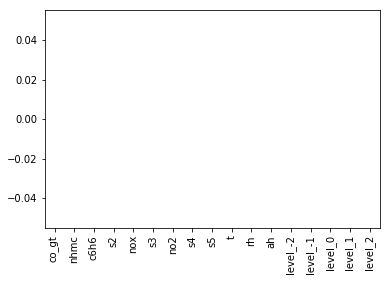

In [24]:
X.isnull().sum().plot(kind='bar')

In [25]:
y = reg_data['y']

In [26]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=7)

# Train validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=7)

In [27]:
def fit_evaluate(model): 
    '''
    Function prints the training and validation scores.
    Args
        Model: Sklearn object with predict method.
    
    Returns
        None
    '''
    model.fit(X_train, y_train)
    train_rmse = np.sqrt(mean_squared_error(y_pred=model.predict(X_train),y_true=y_train))
    val_rmse = np.sqrt(mean_squared_error(y_pred=model.predict(X_val),y_true=y_val))
    print("Train RMSE: ", train_rmse)
    print("Validation RMSE: ", val_rmse)

## Linear Regression with L2

In [28]:
lm_ridge = Ridge()
fit_evaluate(lm_ridge)

Train RMSE:  254.101282695
Validation RMSE:  262.765394359


## Linear Regression with L1

In [29]:
lm_lasso = Lasso()
fit_evaluate(lm_lasso)

Train RMSE:  254.2004603
Validation RMSE:  262.949514994


/Users/avinash/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


## Random Forest Regressor

In [30]:
rf_reg = RandomForestRegressor()
fit_evaluate(rf_reg)

Train RMSE:  107.21900472
Validation RMSE:  242.798547787


## K Neighbors Regressors

In [31]:
kn_reg = KNeighborsRegressor()
fit_evaluate(kn_reg)

Train RMSE:  208.284334222
Validation RMSE:  268.894847743


## Support Vector Regressor

In [32]:
sv_reg = SVR()
fit_evaluate(sv_reg)

Train RMSE:  338.910069572
Validation RMSE:  347.345756098


## GradientBoostingRegressor

In [33]:
gb_reg = GradientBoostingRegressor()
fit_evaluate(gb_reg)

Train RMSE:  221.974210789
Validation RMSE:  247.430033941


## AdaBoostRegressor

In [34]:
ab_reg = AdaBoostRegressor()
fit_evaluate(ab_reg)

Train RMSE:  289.83016992
Validation RMSE:  299.986877207


## XGBRegressor

In [35]:
xgb_reg = XGBRegressor()
fit_evaluate(xgb_reg)

Train RMSE:  223.988838639
Validation RMSE:  246.590412433


## Hyperparameter tuning for RandomForestRegressor

In [92]:
parameters = {'n_estimators': np.arange(100,300,50),
              'max_features': ['auto', 'sqrt'],
              'max_depth': [None, 5, 7, 10]}

In [50]:
rf_reg = RandomForestRegressor()
opt_gbc = GridSearchCV(rf_reg, parameters, n_jobs = -1)
opt_gbc.fit(X_train,y_train)
print(opt_gbc.best_params_)

{'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 250}


In [169]:
rf_reg_opt = RandomForestRegressor(max_depth = None, max_features = 'sqrt', n_estimators = 250)
fit_evaluate(rf_reg_opt)

Train RMSE:  91.7865152843
Validation RMSE:  234.277532199


## Hyperparameter tuning for GradientBoostingRegressor

In [52]:
parameters = {'learning_rate' : np.logspace(-2,0,num=3),
              'n_estimators': [100, 200, 250], 
              'max_depth':[3,5,7], 
              'max_features': ['auto', 'sqrt']}

In [53]:
gb_reg = GradientBoostingRegressor()
opt_gbc = GridSearchCV(gb_reg, parameters, n_jobs = -1)
opt_gbc.fit(X_train,y_train)
print(opt_gbc.best_params_)

{'learning_rate': 0.10000000000000001, 'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 250}


In [170]:
gb_reg_opt = GradientBoostingRegressor(learning_rate = 0.1, max_depth = 7,
                                       max_features = 'sqrt', n_estimators = 250)
fit_evaluate(gb_reg_opt)

Train RMSE:  85.0183499908
Validation RMSE:  234.518576764


## Feature Selection

In [171]:
def evaluate(model): 
    train_rmse = np.sqrt(mean_squared_error(y_pred=model.predict(X_train),y_true=y_train))
    val_rmse = np.sqrt(mean_squared_error(y_pred=model.predict(X_val),y_true=y_val))
    print("Train RMSE: ", train_rmse)
    print("Validation RMSE: ", val_rmse)

#### Using Extra trees regressor for feature selection

In [172]:
etr_pipeline = Pipeline([
  ('feature_selection', SelectFromModel(ExtraTreesRegressor(n_estimators=250, random_state=7))),
  ('classification', RandomForestRegressor(max_depth = None, max_features = 'sqrt', n_estimators = 250))
])
etr_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('feature_selection', SelectFromModel(estimator=ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          ...imators=250, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))])

In [173]:
evaluate(etr_pipeline)

Train RMSE:  132.270682794
Validation RMSE:  256.687751746


#### Using Lasso for feature selection

In [174]:
lasso_pipeline = Pipeline([
  ('feature_selection', SelectFromModel(Lasso())),
  ('classification', RandomForestRegressor(max_depth = None, max_features = 'sqrt', n_estimators = 250))
])

lasso_pipeline.fit(X_train, y_train)

/Users/avinash/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Pipeline(memory=None,
     steps=[('feature_selection', SelectFromModel(estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
        norm_order=1, prefit=False, threshold=None)),...imators=250, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))])

In [175]:
evaluate(lasso_pipeline)

Train RMSE:  92.1024429127
Validation RMSE:  234.752332245


#### Using LinearSVR feature selection

In [176]:
svr_pipeline = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVR(C=0.1))),
  ('classification', RandomForestRegressor(max_depth = None, max_features = 'sqrt', n_estimators = 250))
])

svr_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('feature_selection', SelectFromModel(estimator=LinearSVR(C=0.1, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0),
        norm_order=1, prefit=False, threshold=None)), ('classific...imators=250, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))])

In [177]:
evaluate(svr_pipeline)

Train RMSE:  133.445987143
Validation RMSE:  267.170625337


## Test RMSE with the best model

In [178]:
test_rmse = np.sqrt(mean_squared_error(y_pred=lasso_pipeline.predict(X_test),y_true=y_test))
print("Test RMSE: ", test_rmse)

Test RMSE:  227.086358812


## Saving final model

In [58]:
save_classifier = open("../results/pickles/task2_model.pickle", "wb")
pickle.dump(lasso_pipeline, save_classifier)
save_classifier.close()